# Imports

In [37]:
import json
from pathlib import Path
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [38]:
@dataclass
class Result1D:
    x_values: List[float]
    y_values: List[float]
    x_name: str
    y_name: str
    x_unit: str
    y_unit: str

    # shorter string representation, including length of data for x and y values
    def __repr__(self):
        return f'Result1D({self.x_name} ({len(self.x_values)}), {self.y_name} ({len(self.y_values)}))'

In [39]:
def list_of_estimators(json_filepath : Path) -> List[str]:
    estimators = []
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        estimators = [estimator["name"] for estimator in bp_mc_data_sh12a["estimators"]]
    return estimators

def list_of_pages(json_filepath : Path, estimator_name : str) -> List[str]:
    pages = []
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        for estimator in bp_mc_data_sh12a["estimators"]:
            if estimator['name'] == estimator_name:
                pages = [page["name"] for page in estimator["pages"]]
    return pages

def get_data_1d(json_filepath : Path, estimator_name : str, page_name : str) -> Result1D:
    result = Result1D([], [], "", "", "", "")
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        for estimator in bp_mc_data_sh12a["estimators"]:
            if estimator['name'] == estimator_name:
                for page in estimator["pages"]:
                    if page["name"] == page_name:
                        result.x_values = page["axisDim1"]["values"]
                        result.y_values = page["data"]["values"]
                        result.x_name = page["axisDim1"]["name"]
                        result.y_name = page["data"]["name"]
                        result.x_unit = page["axisDim1"]["unit"]
                        result.y_unit = page["data"]["unit"]
    return result

In [40]:
def x_at_y(x: List[float], y: List[float], ynew: float, reverse=False) -> float:
    """
    Calculates inverse profile - for given ynew returns xnew such that f(xnew) = ynew
    If given y is not found in the self.y, then interpolation is used.
    By default returns first result looking from left,
    if reverse argument set to True, looks from right. 
    If y is outside range of `y` then np.nan is returned.

    :param x: reference value
    :param y: reference value
    :param reverse: boolean value - direction of lookup
    :return: x value corresponding to given y or NaN if not found
    """
    # positive or negative direction handles
    x_handle, y_handle = np.asarray(x), np.asarray(y)
    if reverse:
        x_handle, y_handle = np.flip(x_handle), np.flip(y_handle)

    # find the index of first value in y greater or equal than ynew
    cond = y_handle >= ynew
    ind = np.argmax(cond)

    # two boundary conditions where x cannot be found:
    # A) ynew > max(y)
    # B) ynew < min(y)

    # A) if ynew > max(y) then condition y >= ynew
    #   will never be satisfied
    #   np.argmax( cond ) will be equal 0  and  cond[ind] will be False
    if not cond[ind]:
        return np.nan

    # B) if ynew < min(y) then condition y >= ynew
    #   will be satisfied on first item
    #   np.argmax(cond) will be equal 0,
    #   to exclude situation that y_handle[0] = ynew
    #   we also check if ynew < y_handle[0]
    if ind == 0 and ynew < y_handle[0]:
        return np.nan

    # use lookup if ynew in y:
    if cond[ind] and y_handle[ind] == ynew:
        return x_handle[ind]

    # use linear interpolation
    sl = slice(ind - 1, ind + 1)
    return float(np.interp(ynew, y_handle[sl], x_handle[sl]))


def beam_range(x: List[float], y: List[float], falloff_threshold: float = 0.9) -> float:
    falloff_threshold_dose = falloff_threshold * max(y)
    return x_at_y(x=x, y=y, ynew=falloff_threshold_dose, reverse=True)

# Data loading

In [41]:
path_to_this_notebook = Path.cwd()

In [42]:
bp_mc_data_file_sh12a = path_to_this_notebook / 'shield-hit12a' / 'results_bp.json'

In [43]:
list_of_estimators(bp_mc_data_file_sh12a)

['z_profile',
 'yz_profile',
 'slab_at_0mm',
 'slab_at_15mm',
 'slab_at_27mm',
 'slab_at_28mm',
 'xy_profile_entry']

In [44]:
list_of_pages(bp_mc_data_file_sh12a, estimator_name='z_profile')

['Dose',
 'FluenceProtons',
 'FluencePrimaries',
 'FluenceSecondaryProtons',
 'KineticEnergyProtons',
 'KineticEnergyPrimaries',
 'KineticEnergySecondaryProtons',
 'BetaProtons',
 'BetaPrimaries',
 'KineticEnergyDoseSpectrum',
 'KineticEnergyFluenceSpectrum',
 'dLETProtons',
 'dLETPrimaries',
 'tLETProtons',
 'tLETPrimaries']

In [45]:
list_of_pages(bp_mc_data_file_sh12a, estimator_name='slab_at_0mm')

['KineticEnergyPrimaries',
 'KineticEnergyProtons',
 'KineticEnergySecondaryProtons',
 'dLETProtons',
 'tLETProtons',
 'ProtonsKineticEnergySpectrum',
 'PrimaryProtonsKineticEnergySpectrum',
 'SecondaryProtonsKineticEnergySpectrum']

In [46]:
list_of_pages(bp_mc_data_file_sh12a, estimator_name='slab_at_15mm')

['ProtonsKineticEnergySpectrum',
 'PrimaryProtonsKineticEnergySpectrum',
 'SecondaryProtonsKineticEnergySpectrum']

# Plots - BP

## Depth dose profile - validation

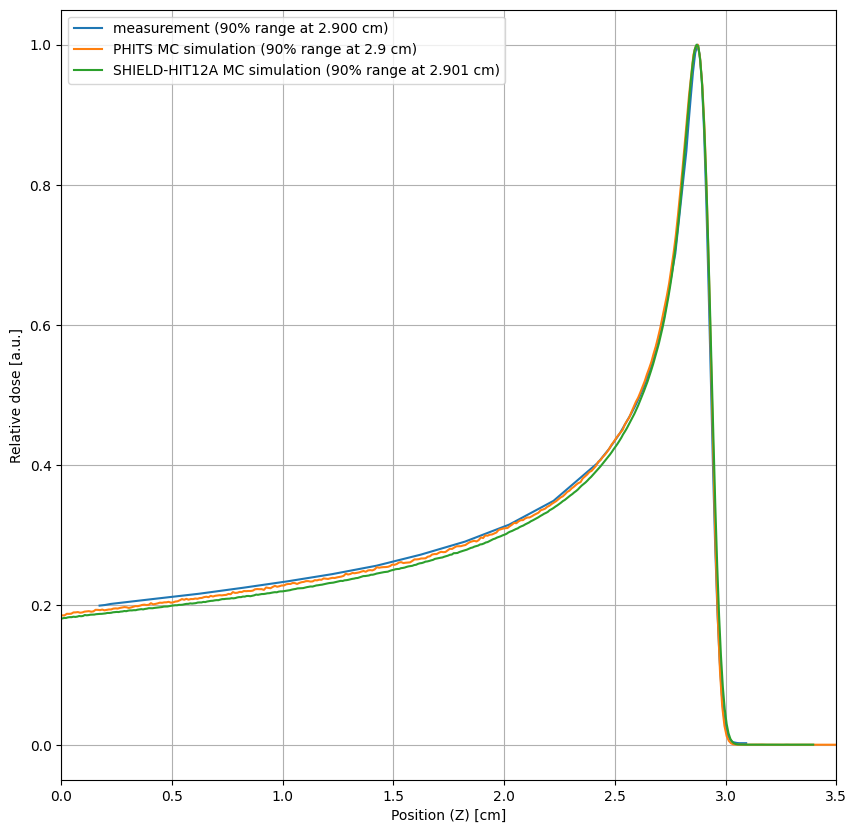

In [47]:
depth_dose_sh12a = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="Dose")
# calculate depth at which dose is equal to 90% of maximum dose, starting from the end of the list
depth_dose_sh12a_90 = beam_range(x=depth_dose_sh12a.x_values, y=depth_dose_sh12a.y_values)

depth_dose_phits = pd.read_csv(path_to_this_notebook / 'phits' / 'depth_dose_bp.csv')
depth_dose_phits['z_cm'] = depth_dose_phits['z_mm'] / 10
# calculate depth at which dose is equal to 90% of maximum dose
depth_dose_phits_90 = beam_range(x=depth_dose_phits['z_cm'].to_list(), y=depth_dose_phits['dose'].to_list())

depth_dose_measurement = pd.read_csv(path_to_this_notebook / 'measurement' / 'depth_dose_bp.csv')
depth_dose_measurement['depth_cm'] = depth_dose_measurement['Depth'] / 10
# calculate depth at which dose is equal to 90% of maximum dose
depth_dose_measurement_90 = beam_range(x=depth_dose_measurement['depth_cm'].to_list(), y=depth_dose_measurement['Signal'].to_list())

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(depth_dose_measurement['depth_cm'], depth_dose_measurement['Signal'], label = f'measurement (90% range at {depth_dose_measurement_90:.3f} cm)')
ax.plot(depth_dose_phits['z_cm'], depth_dose_phits['dose'], label = f'PHITS MC simulation (90% range at {depth_dose_phits_90:.3} cm)')
ax.plot(depth_dose_sh12a.x_values, [dose/max(depth_dose_sh12a.y_values) for dose in depth_dose_sh12a.y_values], label = f'SHIELD-HIT12A MC simulation (90% range at {depth_dose_sh12a_90:.3f} cm)')
ax.set_xlabel(f"{depth_dose_sh12a.x_name} [{depth_dose_sh12a.x_unit}]")
ax.set_ylabel(f"Relative dose [a.u.]")
ax.grid(True)
ax.set_xlim(0, 3.5)
ax.legend();


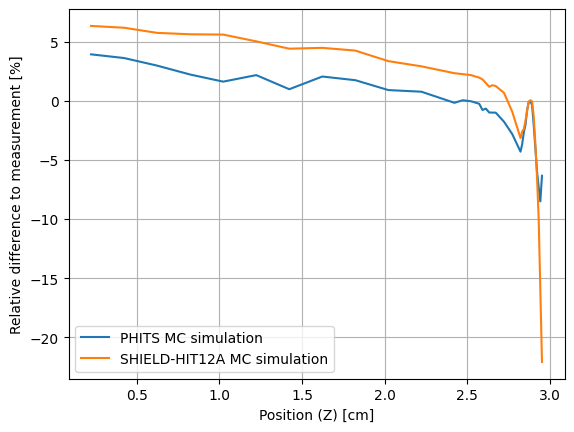

In [48]:
# get interpolated PHITS data at measurement depths, using scipy spline interpolation function
phits_dose_at_measurement_depths = interp1d(depth_dose_phits['z_cm'], depth_dose_phits['dose'], kind='cubic')(depth_dose_measurement['depth_cm'])

# get interpolated SHIELD-HIT12A data at measurement depths, using scipy spline interpolation function
shieldhit12a_dose_at_measurement_depths = interp1d(depth_dose_sh12a.x_values, [dose/max(depth_dose_sh12a.y_values) for dose in depth_dose_sh12a.y_values], kind='cubic')(depth_dose_measurement['depth_cm'])

# calculate relative difference between measurement and PHITS simulation
relative_difference_phits = (depth_dose_measurement['Signal'] - phits_dose_at_measurement_depths) / depth_dose_measurement['Signal']

# calculate relative difference between measurement and SHIELD-HIT12A simulation
relative_difference_shieldhit12a = (depth_dose_measurement['Signal'] - shieldhit12a_dose_at_measurement_depths) / depth_dose_measurement['Signal']

# plot relative difference between SHIELD-HIT12A, PHITS simulations and measurement in percent, limit the plot to the such depth for which dose > 0.05
fig, ax = plt.subplots()
threshold = 0.2
cond = depth_dose_measurement['Signal'] > threshold
ax.plot(depth_dose_measurement['depth_cm'][cond], relative_difference_phits[cond]*100, label = 'PHITS MC simulation')
ax.plot(depth_dose_measurement['depth_cm'][cond], relative_difference_shieldhit12a[cond]*100, label = 'SHIELD-HIT12A MC simulation')
ax.set_xlabel(f"{depth_dose_sh12a.x_name} [{depth_dose_sh12a.x_unit}]")
ax.set_ylabel(f"Relative difference to measurement [%]")
ax.grid(True)
ax.legend();

## Kinetic energy - cross-check

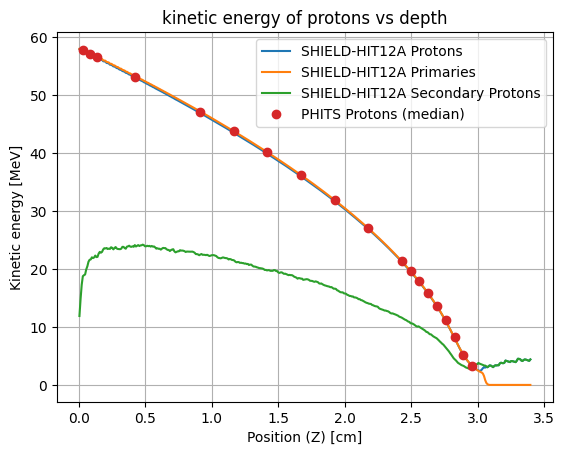

In [49]:
KineticEnergyProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="KineticEnergyProtons")
KineticEnergyPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="KineticEnergyPrimaries")
KineticEnergySecondaryProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="KineticEnergySecondaryProtons")

phits_mean_kinetic_energy = pd.read_csv(path_to_this_notebook / 'phits' / 'kinetic_energy_bp.csv')
phits_mean_kinetic_energy['z_cm'] = phits_mean_kinetic_energy['z_mm'] / 10

fig, ax = plt.subplots()
ax.set_title("kinetic energy of protons vs depth")
ax.plot(KineticEnergyProtons.x_values, KineticEnergyProtons.y_values, label="SHIELD-HIT12A Protons")
ax.plot(KineticEnergyPrimaries.x_values, KineticEnergyPrimaries.y_values, label="SHIELD-HIT12A Primaries")
ax.plot(KineticEnergySecondaryProtons.x_values, KineticEnergySecondaryProtons.y_values, label="SHIELD-HIT12A Secondary Protons")
# plot PHITS data with points
ax.plot(phits_mean_kinetic_energy['z_cm'], phits_mean_kinetic_energy['ef_q50'], 'o', label="PHITS Protons (median)")

ax.set_xlabel(f"{KineticEnergyProtons.x_name} [{KineticEnergyProtons.x_unit}]")
ax.set_ylabel(f"Kinetic energy [{KineticEnergyProtons.y_unit}]")
ax.grid(True)
ax.legend();

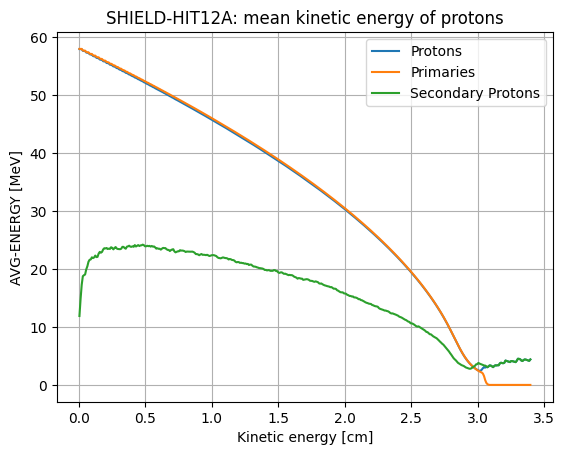

In [50]:
KineticEnergyProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="KineticEnergyProtons")
KineticEnergyPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="KineticEnergyPrimaries")
KineticEnergySecondaryProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="KineticEnergySecondaryProtons")

fig, ax = plt.subplots()
ax.set_title("SHIELD-HIT12A: mean kinetic energy of protons")
ax.plot(KineticEnergyProtons.x_values, KineticEnergyProtons.y_values, label="Protons")
ax.plot(KineticEnergyPrimaries.x_values, KineticEnergyPrimaries.y_values, label="Primaries")
ax.plot(KineticEnergySecondaryProtons.x_values, KineticEnergySecondaryProtons.y_values, label="Secondary Protons")
ax.set_xlabel(f"Kinetic energy [{KineticEnergyProtons.x_unit}]")
ax.set_ylabel(f"{KineticEnergyProtons.y_name} [{KineticEnergyProtons.y_unit}]")
ax.grid(True)
ax.legend();

## Others - SHIELD-HIT12A simulation

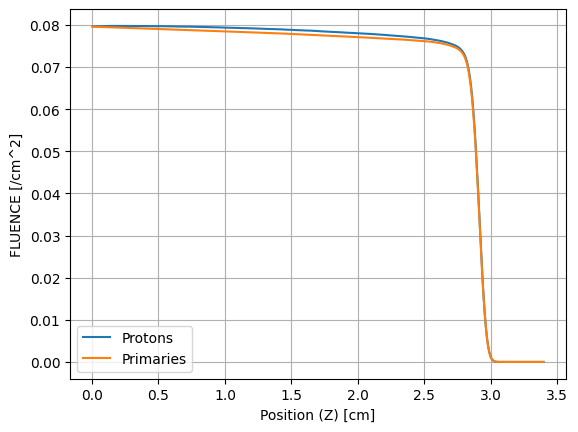

In [51]:
fluence_protons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="FluenceProtons")
fluence_primaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="FluencePrimaries")

fig, ax = plt.subplots()
ax.plot(fluence_protons.x_values, fluence_protons.y_values, label="Protons")
ax.plot(fluence_primaries.x_values, fluence_primaries.y_values, label="Primaries")
ax.set_xlabel(f"{fluence_protons.x_name} [{fluence_protons.x_unit}]")
ax.set_ylabel(f"{fluence_protons.y_name} [{fluence_protons.y_unit}]")
ax.grid(True)
ax.legend();

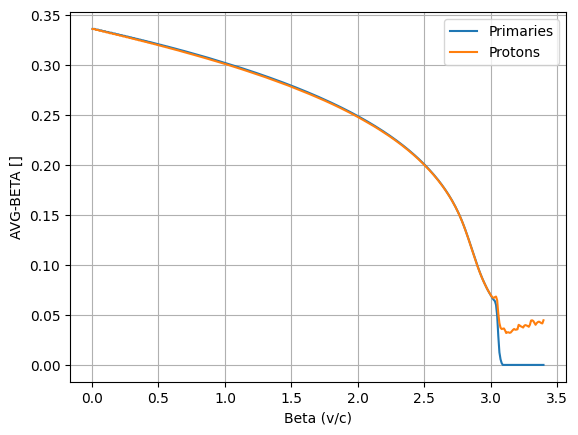

In [52]:
dLETPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="BetaPrimaries")
dLETProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="BetaProtons")

fig, ax = plt.subplots()
ax.plot(dLETPrimaries.x_values, dLETPrimaries.y_values, label="Primaries")
ax.plot(dLETProtons.x_values, dLETProtons.y_values, label="Protons")
ax.set_xlabel(f"Beta (v/c)")
ax.set_ylabel(f"{dLETPrimaries.y_name} [{dLETPrimaries.y_unit}]")
ax.grid(True)
ax.legend();

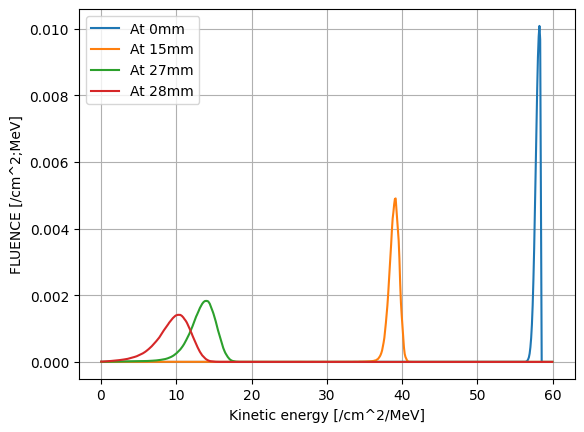

In [53]:
ProtonsKineticEnergySpectrumAt0mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_0mm", page_name="ProtonsKineticEnergySpectrum")
ProtonsKineticEnergySpectrumAt15mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_15mm", page_name="ProtonsKineticEnergySpectrum")
ProtonsKineticEnergySpectrumAt27mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_27mm", page_name="ProtonsKineticEnergySpectrum")
ProtonsKineticEnergySpectrumAt28mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_28mm", page_name="ProtonsKineticEnergySpectrum")

fig, ax = plt.subplots()
ax.plot(ProtonsKineticEnergySpectrumAt0mm.x_values, ProtonsKineticEnergySpectrumAt0mm.y_values, label="At 0mm")
ax.plot(ProtonsKineticEnergySpectrumAt15mm.x_values, ProtonsKineticEnergySpectrumAt15mm.y_values, label="At 15mm")
ax.plot(ProtonsKineticEnergySpectrumAt27mm.x_values, ProtonsKineticEnergySpectrumAt27mm.y_values, label="At 27mm")
ax.plot(ProtonsKineticEnergySpectrumAt28mm.x_values, ProtonsKineticEnergySpectrumAt28mm.y_values, label="At 28mm")
ax.set_xlabel(f"Kinetic energy [{ProtonsKineticEnergySpectrumAt0mm.x_unit}]")
ax.set_ylabel(f"{ProtonsKineticEnergySpectrumAt0mm.y_name} [{ProtonsKineticEnergySpectrumAt0mm.y_unit}]")
ax.grid(True)
ax.legend();

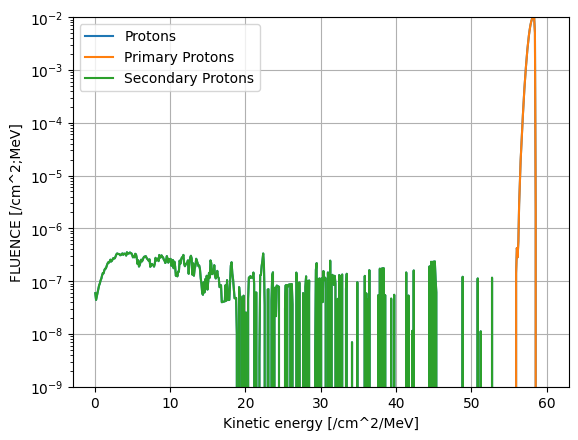

In [54]:
ProtonsKineticEnergySpectrumAt0mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_0mm", page_name="ProtonsKineticEnergySpectrum")
PrimaryProtonsKineticEnergySpectrumAt0mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_0mm", page_name="PrimaryProtonsKineticEnergySpectrum")
SecondaryProtonsKineticEnergySpectrumAt0mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_0mm", page_name="SecondaryProtonsKineticEnergySpectrum")

fig, ax = plt.subplots()
ax.plot(ProtonsKineticEnergySpectrumAt0mm.x_values, ProtonsKineticEnergySpectrumAt0mm.y_values, label="Protons")
ax.plot(PrimaryProtonsKineticEnergySpectrumAt0mm.x_values, PrimaryProtonsKineticEnergySpectrumAt0mm.y_values, label="Primary Protons")
ax.plot(SecondaryProtonsKineticEnergySpectrumAt0mm.x_values, SecondaryProtonsKineticEnergySpectrumAt0mm.y_values, label="Secondary Protons")
ax.set_xlabel(f"Kinetic energy [{ProtonsKineticEnergySpectrumAt0mm.x_unit}]")
ax.set_ylabel(f"{ProtonsKineticEnergySpectrumAt0mm.y_name} [{ProtonsKineticEnergySpectrumAt0mm.y_unit}]")
ax.grid(True)
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-9, 1e-2);

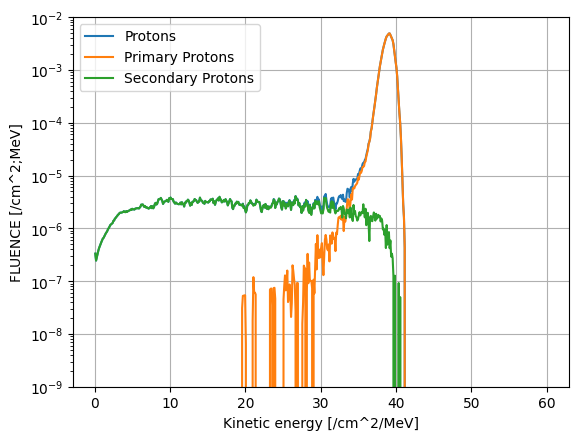

In [55]:
ProtonsKineticEnergySpectrumAt15mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_15mm", page_name="ProtonsKineticEnergySpectrum")
PrimaryProtonsKineticEnergySpectrumAt15mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_15mm", page_name="PrimaryProtonsKineticEnergySpectrum")
SecondaryProtonsKineticEnergySpectrumAt15mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_15mm", page_name="SecondaryProtonsKineticEnergySpectrum")

fig, ax = plt.subplots()
ax.plot(ProtonsKineticEnergySpectrumAt15mm.x_values, ProtonsKineticEnergySpectrumAt15mm.y_values, label="Protons")
ax.plot(PrimaryProtonsKineticEnergySpectrumAt15mm.x_values, PrimaryProtonsKineticEnergySpectrumAt15mm.y_values, label="Primary Protons")
ax.plot(SecondaryProtonsKineticEnergySpectrumAt15mm.x_values, SecondaryProtonsKineticEnergySpectrumAt15mm.y_values, label="Secondary Protons")
ax.set_xlabel(f"Kinetic energy [{ProtonsKineticEnergySpectrumAt15mm.x_unit}]")
ax.set_ylabel(f"{ProtonsKineticEnergySpectrumAt15mm.y_name} [{ProtonsKineticEnergySpectrumAt15mm.y_unit}]")
ax.grid(True)
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-9, 1e-2);

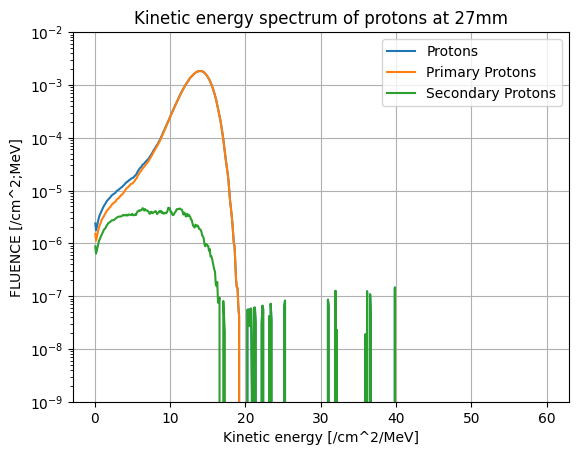

In [56]:
ProtonsKineticEnergySpectrumAt27mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_27mm", page_name="ProtonsKineticEnergySpectrum")
PrimaryProtonsKineticEnergySpectrumAt27mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_27mm", page_name="PrimariesKineticEnergySpectrum")
SecondaryProtonsKineticEnergySpectrumAt27mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_27mm", page_name="SecondaryProtonsKineticEnergySpectrum")

fig, ax = plt.subplots()
ax.set_title("Kinetic energy spectrum of protons at 27mm")
ax.plot(ProtonsKineticEnergySpectrumAt27mm.x_values, ProtonsKineticEnergySpectrumAt27mm.y_values, label="Protons")
ax.plot(PrimaryProtonsKineticEnergySpectrumAt27mm.x_values, PrimaryProtonsKineticEnergySpectrumAt27mm.y_values, label="Primary Protons")
ax.plot(SecondaryProtonsKineticEnergySpectrumAt27mm.x_values, SecondaryProtonsKineticEnergySpectrumAt27mm.y_values, label="Secondary Protons")
ax.set_xlabel(f"Kinetic energy [{ProtonsKineticEnergySpectrumAt27mm.x_unit}]")
ax.set_ylabel(f"{ProtonsKineticEnergySpectrumAt27mm.y_name} [{ProtonsKineticEnergySpectrumAt27mm.y_unit}]")
ax.grid(True)
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-9, 1e-2);

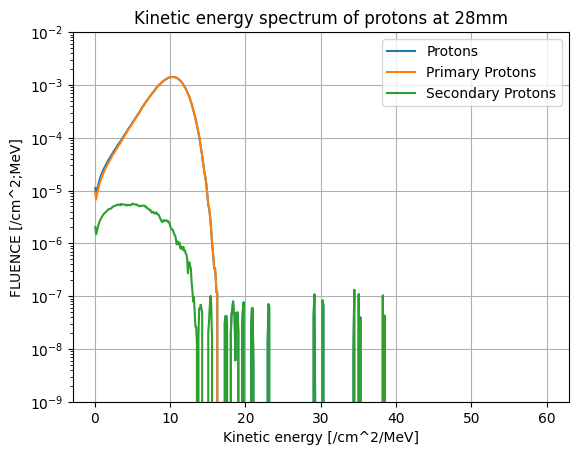

In [57]:
ProtonsKineticEnergySpectrumAt28mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_28mm", page_name="ProtonsKineticEnergySpectrum")
PrimaryProtonsKineticEnergySpectrumAt28mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_28mm", page_name="PrimariesKineticEnergySpectrum")
SecondaryProtonsKineticEnergySpectrumAt28mm = get_data_1d(bp_mc_data_file_sh12a, estimator_name="slab_at_28mm", page_name="SecondaryProtonsKineticEnergySpectrum")

fig, ax = plt.subplots()
ax.set_title("Kinetic energy spectrum of protons at 28mm")
ax.plot(ProtonsKineticEnergySpectrumAt28mm.x_values, ProtonsKineticEnergySpectrumAt28mm.y_values, label="Protons")
ax.plot(PrimaryProtonsKineticEnergySpectrumAt28mm.x_values, PrimaryProtonsKineticEnergySpectrumAt28mm.y_values, label="Primary Protons")
ax.plot(SecondaryProtonsKineticEnergySpectrumAt28mm.x_values, SecondaryProtonsKineticEnergySpectrumAt28mm.y_values, label="Secondary Protons")
ax.set_xlabel(f"Kinetic energy [{ProtonsKineticEnergySpectrumAt28mm.x_unit}]")
ax.set_ylabel(f"{ProtonsKineticEnergySpectrumAt28mm.y_name} [{ProtonsKineticEnergySpectrumAt28mm.y_unit}]")
ax.grid(True)
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-9, 1e-2);

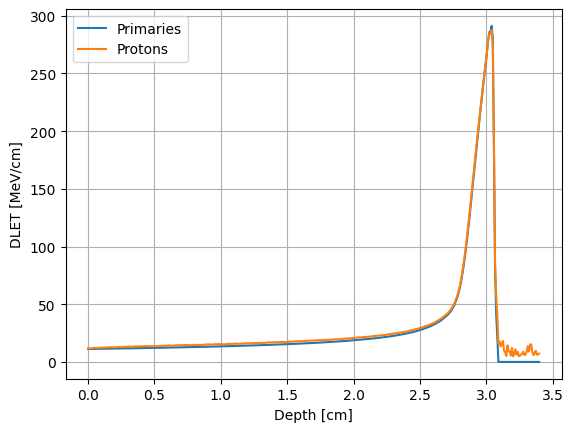

In [58]:
dLETPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETPrimaries")
dLETProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETProtons")

fig, ax = plt.subplots()
ax.plot(dLETPrimaries.x_values, dLETPrimaries.y_values, label="Primaries")
ax.plot(dLETProtons.x_values, dLETProtons.y_values, label="Protons")
ax.set_xlabel(f"Depth [cm]")
ax.set_ylabel(f"{dLETPrimaries.y_name} [{dLETPrimaries.y_unit}]")
ax.grid(True)
ax.legend();

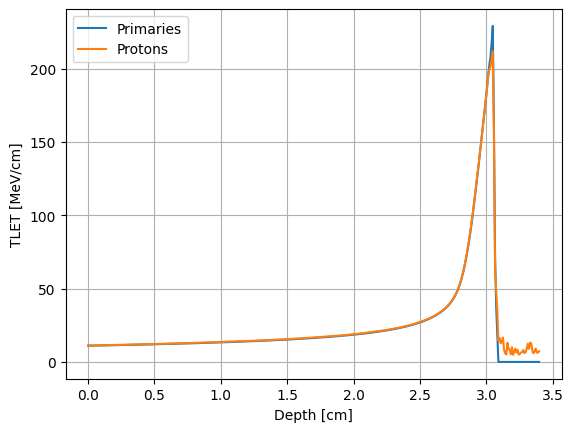

In [59]:
tLETPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETPrimaries")
tLETProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETProtons")

fig, ax = plt.subplots()
ax.plot(tLETPrimaries.x_values, tLETPrimaries.y_values, label="Primaries")
ax.plot(tLETProtons.x_values, tLETProtons.y_values, label="Protons")
ax.set_xlabel(f"Depth [cm]")
ax.set_ylabel(f"{tLETPrimaries.y_name} [{tLETPrimaries.y_unit}]")
ax.grid(True)
ax.legend();